In [3]:
import argparse
from detectron2.engine import DefaultPredictor, default_setup
from detectron2.projects.deeplab import add_deeplab_config
from detectron2.config import get_cfg
from detectron2.utils.colormap import random_color
from mask2former import add_maskformer2_config
import cv2
import os
from tqdm import tqdm
import PIL.Image as Image

/home/xudongw/anaconda3/envs/unsam/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def setup(args):
    """
    Create configs and perform basic setups.
    """
    cfg = get_cfg()
    cfg.set_new_allowed(True)
    # for poly lr schedule
    add_deeplab_config(cfg)
    add_maskformer2_config(cfg)
    cfg.merge_from_file(args.config_file)
    cfg.merge_from_list(args.opts)
    cfg.freeze()
    default_setup(cfg, args)
    return cfg

In [6]:
def get_parser(inputs):
    parser = argparse.ArgumentParser(description="Detectron2 demo for builtin configs")
    parser.add_argument(
        "--config-file",
        default="configs/quick_schedules/mask_rcnn_R_50_FPN_inference_acc_test.yaml",
        metavar="FILE",
        help="path to config file",
    )
    parser.add_argument(
        "--opts",
        help="Modify config options using the command-line 'KEY VALUE' pairs",
        default=[],
        nargs=argparse.REMAINDER,
    )
    args = parser.parse_args(inputs)
    return args

In [7]:
import numpy as np


def area(mask):
    if mask.size == 0:
        return 0
    return np.count_nonzero(mask) / mask.size


def vis_mask(input, mask, mask_color):
    fg = mask > 0.5
    rgb = np.copy(input)
    rgb[fg] = (rgb[fg] * 0.5 + np.array(mask_color) * 0.5).astype(np.uint8)
    return Image.fromarray(rgb)


def show_image(I, pool):
    # the visualization strategy is small masks on top of large masks
    already_painted = np.zeros(np.array(I).shape[:2])
    input = I.copy()
    i = 0
    for mask in tqdm(pool):
        already_painted += mask.astype(np.uint8)
        overlap = already_painted == 2
        if np.sum(overlap) != 0:
            input = Image.fromarray(
                overlap[:, :, np.newaxis] * np.copy(I)
                + np.logical_not(overlap)[:, :, np.newaxis] * np.copy(input)
            )
            already_painted -= overlap
        input = vis_mask(input, mask, random_color(rgb=True))
    display(input)

In [30]:
# Using ***CPU*** by default. to run on cpu, add "MODEL.DEVICE", "cpu".
# By default we only select first 1000 highest confidence score masks. The maximum query is 2000, add "TEST.DETECTIONS_PER_IMAGE", "2000" to get all masks
inputs = [
    "--config-file",
    "configs/maskformer2_R50_bs16_50ep.yaml",
    "--opts",
    "MODEL.WEIGHTS",
    "unsam_plus_sa1b_1perc_ckpt_50k.pth",
]
args = get_parser(inputs)

In [31]:
pred = DefaultPredictor(setup(args))

[06/29 21:03:42 detectron2]: Rank of current process: 0. World size: 1
[06/29 21:03:47 detectron2]: Environment info:
----------------------  ----------------------------------------------------------------------------------------
sys.platform            linux
Python                  3.8.18 (default, Sep 11 2023, 13:40:15) [GCC 11.2.0]
numpy                   1.23.5
detectron2              0.6 @/home/xudongw/anaconda3/envs/unsam/lib/python3.8/site-packages/detectron2
Compiler                GCC 11.2
CUDA compiler           CUDA 11.7
detectron2 arch flags   7.0
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 2.0.1+cu117 @/home/xudongw/anaconda3/envs/unsam/lib/python3.8/site-packages/torch
PyTorch debug build     False
GPU available           Yes
GPU 0,1,2,3,4,5,6,7     NVIDIA A100-SXM4-80GB (arch=8.0)
Driver version          545.23.08
CUDA_HOME               /usr/local/cuda
Pillow                  9.4.0
torchvision             0.15.2+cu117 @/home/xudongw/anaconda3/envs/unsam/l

In [32]:
# specify the path here if you want to try your own images
inputs = cv2.imread("../docs/demos/sa_527160.jpg")
pred.input_format = "BGR"

In [33]:
outputs = pred(inputs)["instances"]

In [34]:
masks = []
for score, mask in zip(outputs.scores, outputs.pred_masks):
    # set the confidence threshold for selecting masks here, you can increase it to speed up the visualization process
    # or you can resize the image to speed up. The example images from SA-1B have relatively high resolution
    if score < 0.5:
        continue
    masks.append(mask.cpu().numpy())
sorted_masks = sorted(masks, key=lambda m: area(m), reverse=True)
print(f"You have {len(sorted_masks)} masks for this image")

You have 428 masks for this image


100%|██████████| 428/428 [00:40<00:00, 10.69it/s]


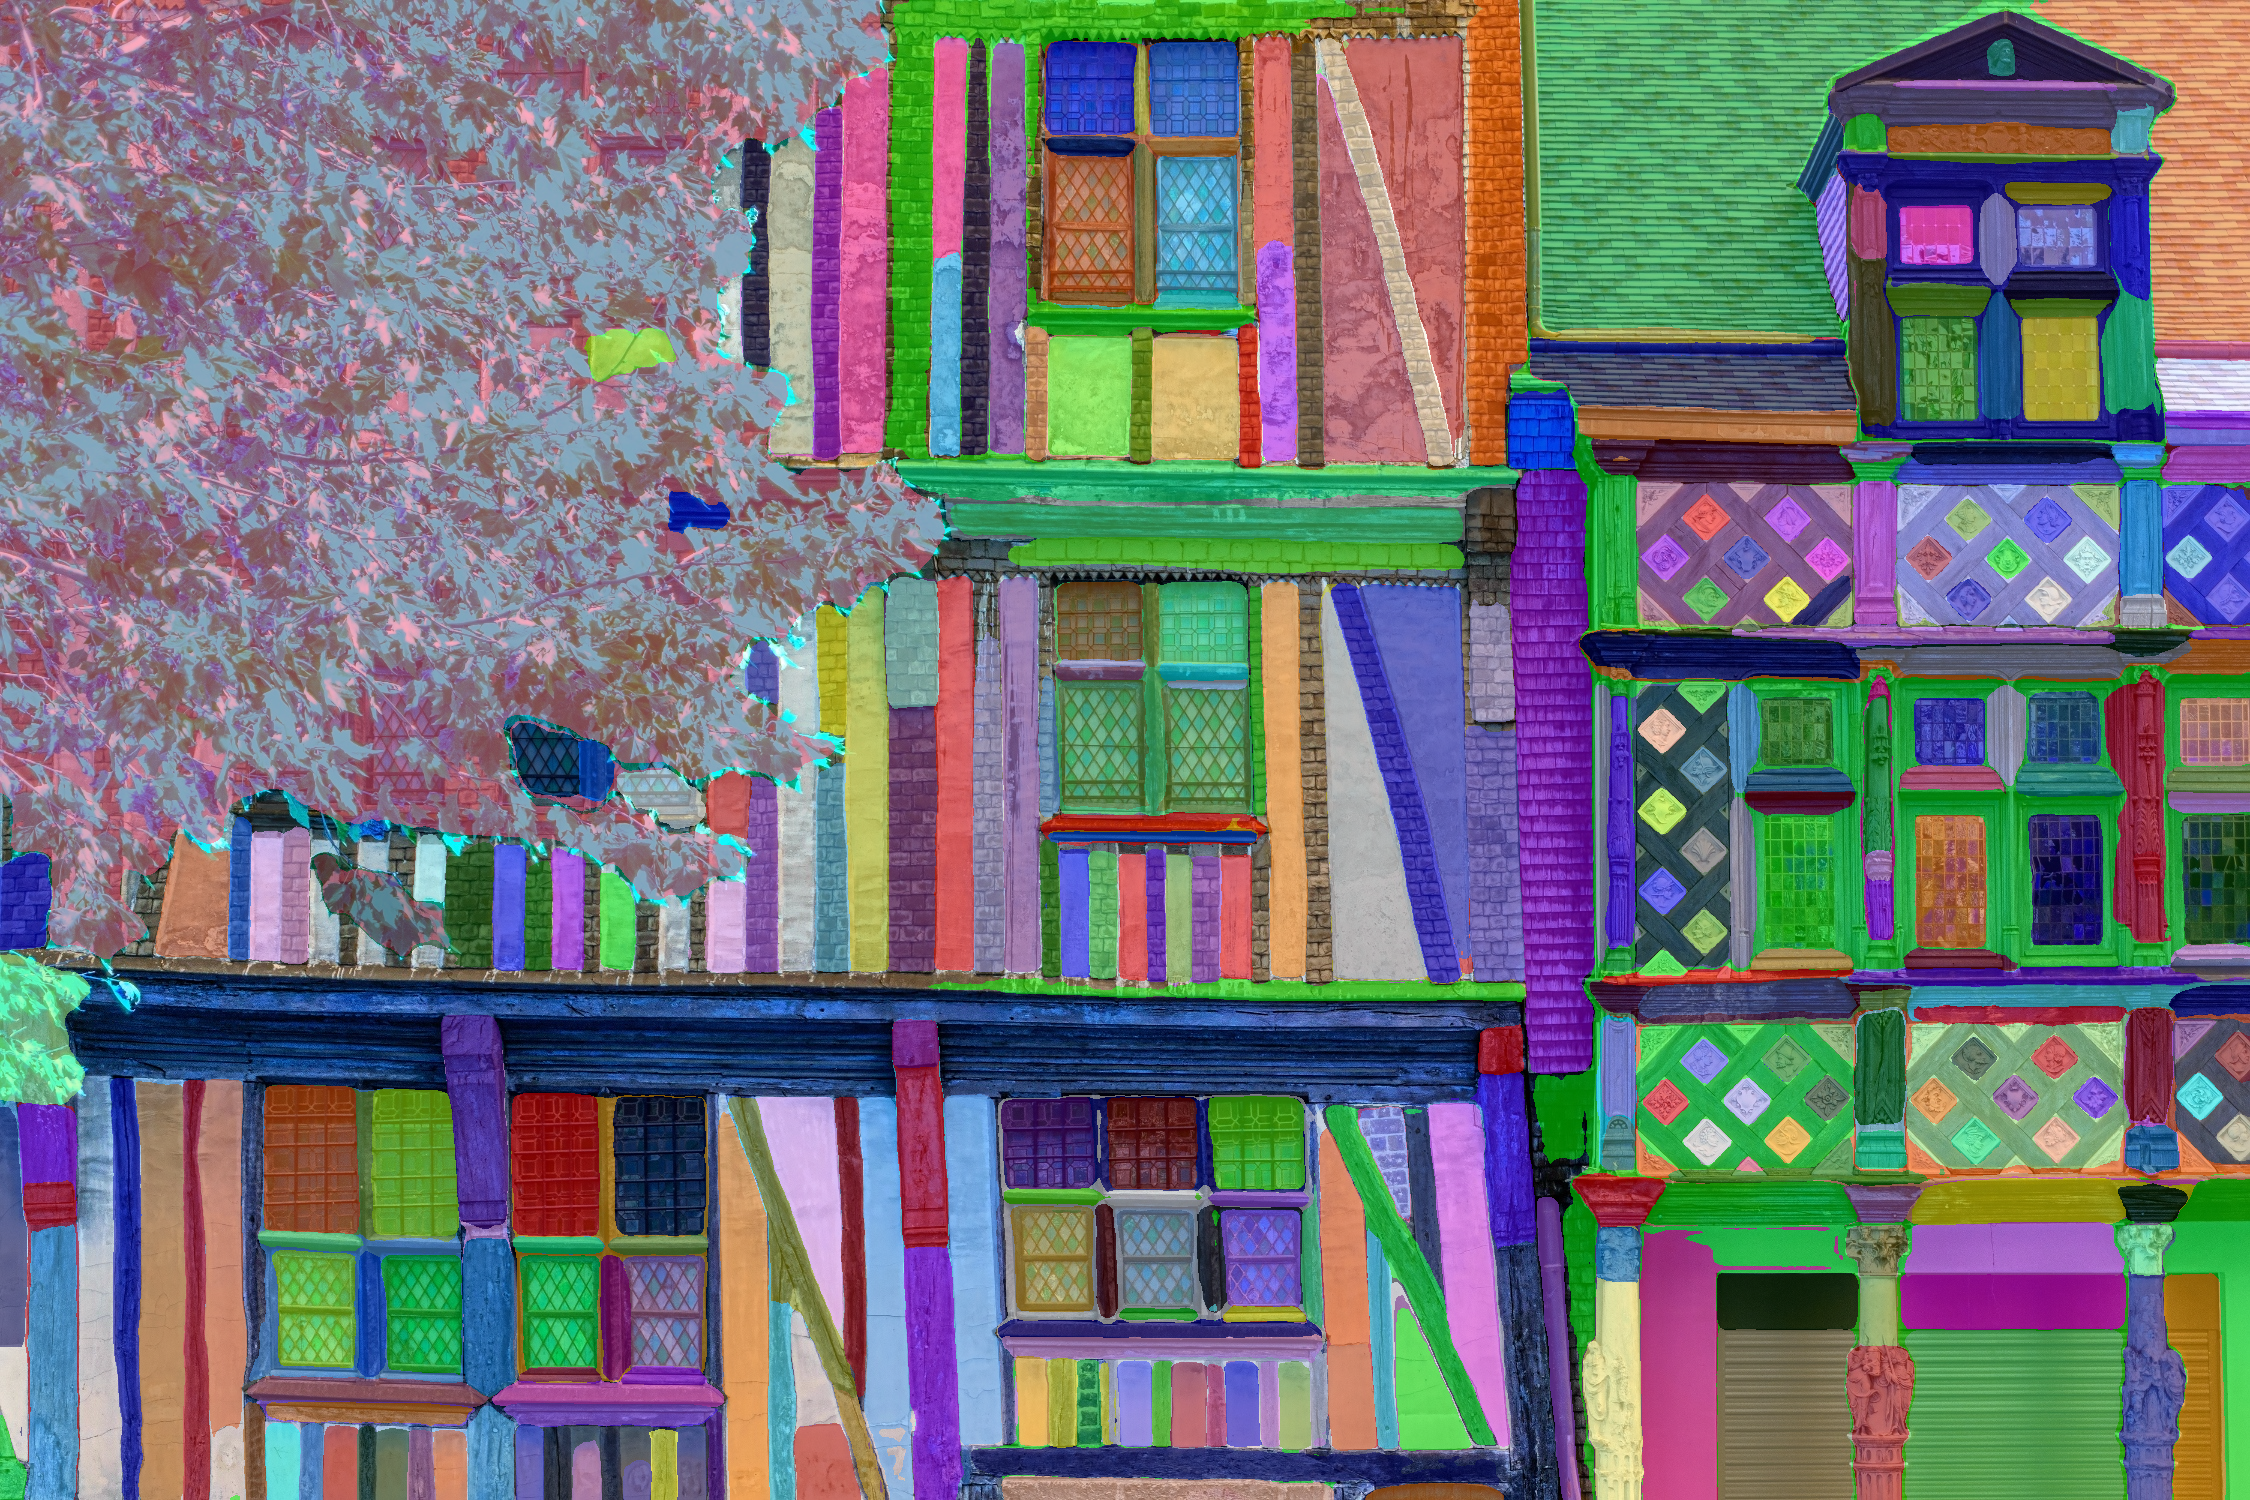

In [35]:
show_image(inputs, sorted_masks)